In [1]:
import calour as ca
import calour_utils as cu

/home/amnon/miniconda3/envs/calour/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


failed to load logging config file


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import shutil
import matplotlib.colors
import skbio as skbio
import seaborn as sbs

# To run the classifier for multiple repeats
## We run it on our server using the following commands:
(to create 25 runs of 3 types:
normal
shuffledest - shuffle the case/control labels of the validation dataset
shufflesrc - shuffle the case/control labels of the training dataset

cd ../classifier
conda activate calour2

nohup ./run_classifier_batch.sh 25 -i ../allsamples/allsamples-no-subsampling-no-bloom.biom -m ../allsamples/allsamples-no-subsampling-no-bloom_sample.txt -o results/regular --uname &

nohup ./run_classifier_batch.sh 25 -i ../allsamples/allsamples-no-subsampling-no-bloom.biom -m ../allsamples/allsamples-no-subsampling-no-bloom_sample.txt -o results/shufflesrc --shuffle-source --uname &

nohup ./run_classifier_batch.sh 25 -i ../allsamples/allsamples-no-subsampling-no-bloom.biom -m ../allsamples/allsamples-no-subsampling-no-bloom_sample.txt -o results/shuffledest --shuffle --uname &


## Output is 3*25 csv files of AUC values
copy them back to here to ../classifier/results/ directory

# load the classifier results

In [4]:
dat=ca.read_amplicon('../allsamples/allsamples-no-subsampling-no-bloom.biom','../allsamples/allsamples-no-subsampling-no-bloom_sample.txt',min_reads=1000,normalize=10000)

/home/amnon/miniconda3/envs/calour/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,69,70,71,72,73,75,77,79,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,106,107,108,109,110,113,114,115,118,119,120,121,122,123,124,125,127,129,131,132,133,134,135,136,137,138,140,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,239,240,241,242,243,260,261,263,264,265,266,267,268,269,270,271,272,273,274,275,276,278,280,281,282,283,284,285,286,288,289,292,293,294,295,297,299,300,301

2022-01-06 08:55:50 WARNING Do you forget to normalize your data? It is required before running this function


In [5]:
def load_resuts(filename):
    print('---------')
    print('loading %s' % filename)
    res=None
    numres = 0
    for cres in glob.glob(filename):
        cdf=pd.read_csv(cres,index_col=0)
        if res is None:
            res = cdf
            numres = 1
            continue
        if np.sum(np.sum(np.isnan(cdf)))>0:
            print('nan in %s in %s' % (cres,filename))
            continue
        if not cdf.columns.equals(res.columns):
            print('error')
        res += cdf
        numres += 1
    if numres == 0:
        raise ValueError('No experiments found for %s' % filename)
    res = res/numres
    print('loaded %d results' % numres)
    return res

In [6]:
studies=pd.read_csv('../studies/index.csv',sep='\t')
studies=studies.fillna(1000)
studies['mf']=studies['sampleid'].astype(int).astype(str)

In [7]:
def plot_clustergram(roc_mat, studies,metric='correlation'):
    ids = [str(x) for x in roc_mat.index.values]
    labels2=[(studies.loc[studies['mf']==str(x),'disease'].values + '(' + studies.loc[studies['mf']==str(x), 'authors'].values + ')')[0] for x in ids]
    labelsd2=[(studies.loc[studies['mf']==str(x),'disease'].values + '(' + studies.loc[studies['mf']==str(x), 'authors'].values + ')' + ' ' + str(x))[0] for x in ids]

    # set up the colors for disease
    diseases = {xx:studies.loc[studies['mf']==xx,'disease'].values[0] for xx in ids}
    disease_colors = {xx:(0,0,0) for xx in diseases.values()}
    disease_colors.update({'HIV': (1.00,0.93,0.35),'Autism': (0.50,0.99,0.52),'Bipolar': (1.00, 0.63, 0.00),
         'IBD_Crohn disease': (0.72,0.11,0.11),'IBD_Ulcerative Colitis': (0.043,1,0.97),
         'IBD_Inflammtory bowel disease': (0.90,0.59,0.043),
         'Diabetes T2': (0.47,0.53,0.80),
         'Depression': (0.48,0.12,0.64),
         'Obesity': (0.25,0.32,0.71),
         'Parkinson': (0.29,0.08,0.55),
         'Schizophrenia': (0.88,0.75,0.91),     
         'Gastroenteritis': (0.94,0.33,0.31),
         'Heart diseases': (0.33,0.43,1.00),
         'Irritable bowel syndrom': (0.90,0.45,0.45),
         'Alzheimer': (0.83, 0.83, 0.83), 'Anorexia': (0.83, 0.83, 0.83), 'Cancer': (0.83, 0.83, 0.83), 'Autoimmun diseases': (0.83, 0.83, 0.83), 'C.difficile infection': (0.83, 0.83, 0.83), 
         'Cancer': (0.83, 0.83, 0.83), 'Chronic fatigue syndrome': (0.83, 0.83, 0.83), 'Diabetes T1': (0.83, 0.83, 0.83),  'Gout': (0.83, 0.83, 0.83),
         'Hepatitis B': (0.83, 0.83, 0.83), 'Hepatitis C': (0.83, 0.83, 0.83), 'Hypertension': (0.83, 0.83, 0.83), 
         'Lupus': (0.83, 0.83, 0.83), 'Pancreatitis': (0.83, 0.83, 0.83), 'Psoriasis': (0.83, 0.83, 0.83), 'Rheumatoid arthritis': (0.83, 0.83, 0.83), 
                
         })
    sbs.set(font_scale=0.6)
#     f=sbs.clustermap(roc_mat,xticklabels=labels2,yticklabels=labels2,cmap='nipy_spectral',metric='cosine',vmin=0,vmax=1,
    f=sbs.clustermap(roc_mat,xticklabels=labels2,yticklabels=labels2,cmap='seismic_r',metric=metric,vmin=0,vmax=1,
                    row_colors=[disease_colors[diseases[x]] for x in ids],
                    col_colors=[disease_colors[diseases[x]] for x in ids])
    row_order = np.array(f.dendrogram_row.reordered_ind)
    col_order = np.array(f.dendrogram_col.reordered_ind)
    for idx,crow in enumerate(row_order):
        ccol = np.where(col_order==crow)[0]
        f.ax_heatmap.plot([ccol,ccol,ccol+0.9,ccol+0.9,ccol],[idx,idx+0.9,idx+0.9,idx,idx],'k',linewidth=1)
    return f

In [8]:
resreal=load_resuts('../classifier/results/regular*roc.csv')
resshufall=load_resuts('../classifier/results/shuffleall*roc.csv')
resshufdest=load_resuts('../classifier/results/shuffledest*roc.csv')
resshufsrc=load_resuts('../classifier/results/shufflesrc*')

---------
loading ../classifier/results/regular*roc.csv
nan in ../classifier/results/regular_13efe62a-97d5-11eb-8d2e-a180eace8ae2_roc.csv in ../classifier/results/regular*roc.csv
nan in ../classifier/results/regular_13d76b40-97d5-11eb-869a-633eca66d98e_roc.csv in ../classifier/results/regular*roc.csv
nan in ../classifier/results/regular_13e47042-97d5-11eb-8c67-29ccd9ca4ba1_roc.csv in ../classifier/results/regular*roc.csv
loaded 47 results
---------
loading ../classifier/results/shuffleall*roc.csv
nan in ../classifier/results/shuffleall_2967a8b8-97d9-11eb-a077-e7799af834b5_roc.csv in ../classifier/results/shuffleall*roc.csv
nan in ../classifier/results/shuffleall_29937326-97d9-11eb-bdd3-a358c3b277ee_roc.csv in ../classifier/results/shuffleall*roc.csv
nan in ../classifier/results/shuffleall_2940367a-97d9-11eb-991f-6d98312de368_roc.csv in ../classifier/results/shuffleall*roc.csv
nan in ../classifier/results/shuffleall_29a9df58-97d9-11eb-8360-9787261da95e_roc.csv in ../classifier/results/s

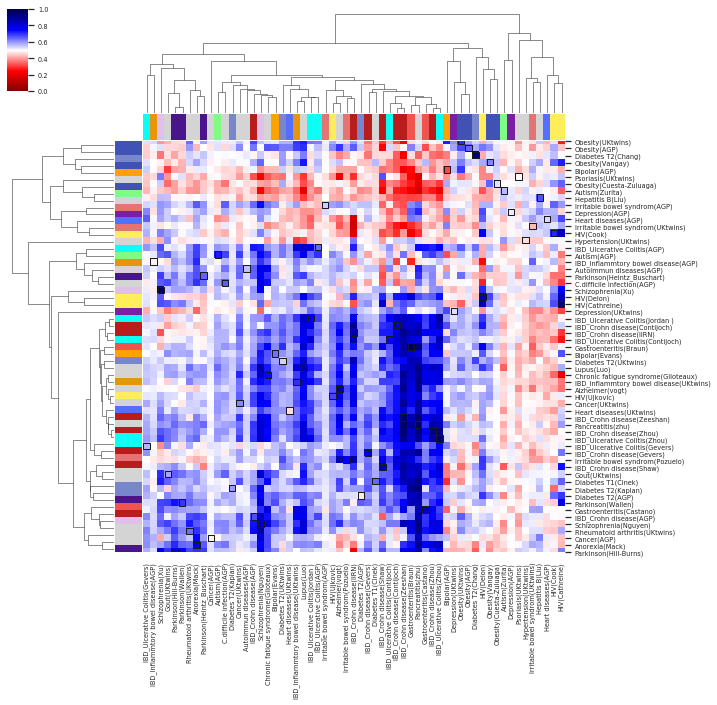

In [9]:
f=plot_clustergram(resreal, studies)
f.savefig('../figures/fig5/ensemble-classifier.pdf')

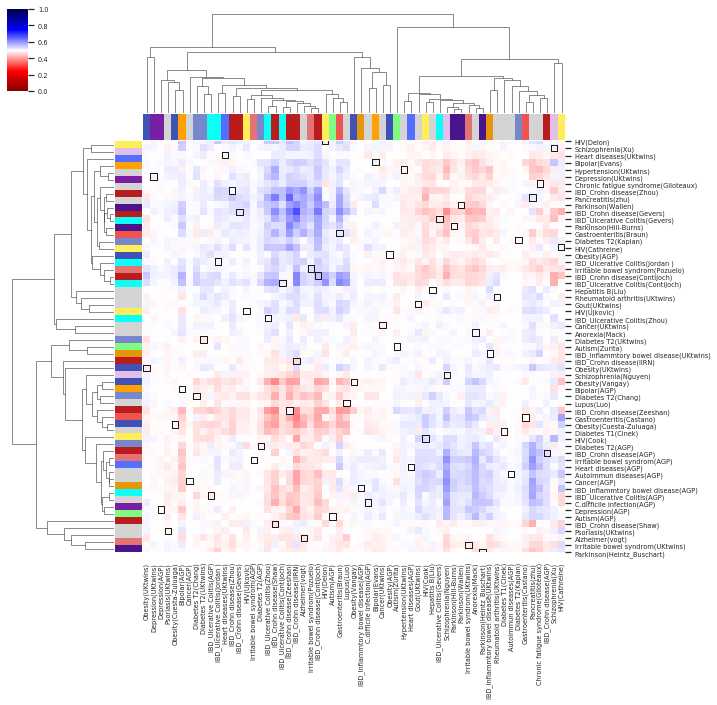

In [10]:
f=plot_clustergram(resshufsrc, studies)
f.savefig('../figures/fig5/ensemble-classifier-shuffle-source.pdf')

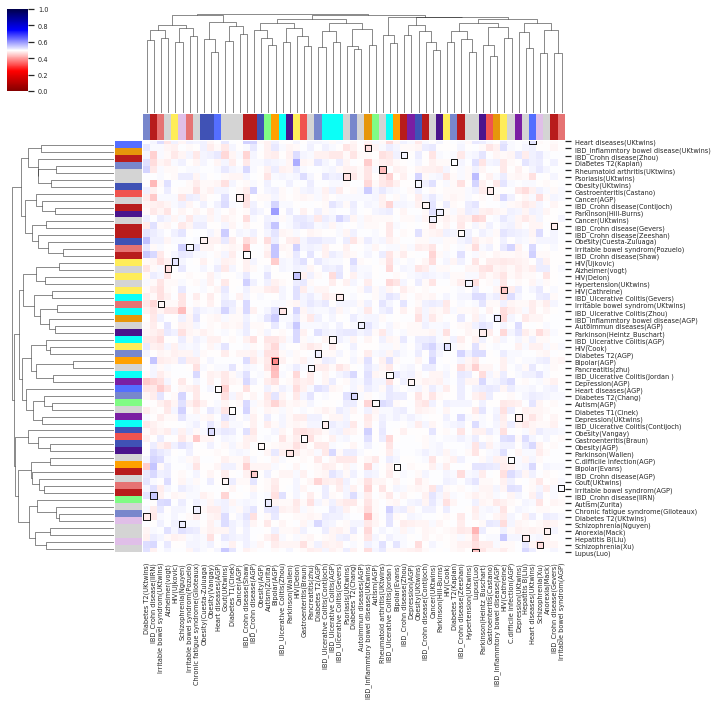

In [11]:
f=plot_clustergram(resshufdest,studies)
f.savefig('../figures/fig5/ensemble-classifier-shuffle-dest.pdf')

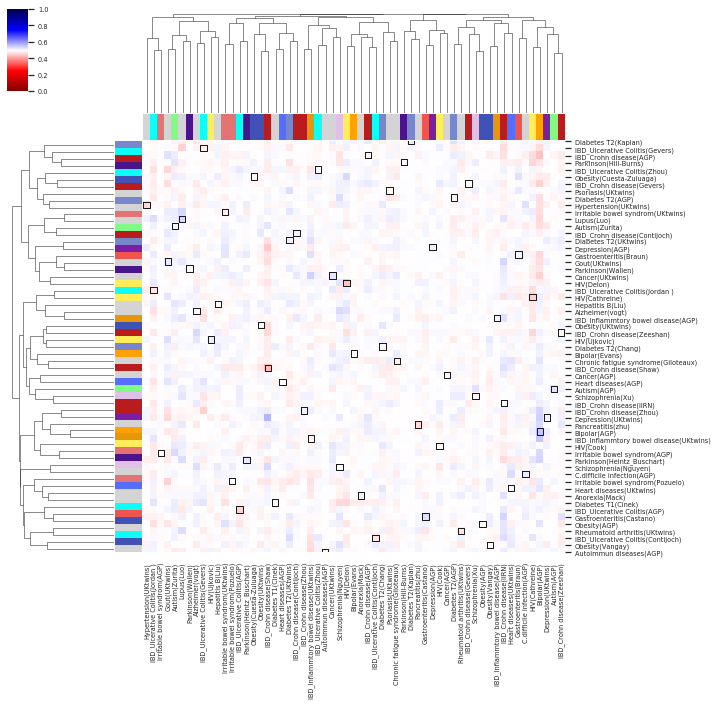

In [12]:
f=plot_clustergram(resshufall,studies)
f.savefig('../figures/fig5/ensemble-classifier-shuffle-all.pdf')

# Now plot the accuracy (corrected)

In [13]:
accreal=load_resuts('../classifier/results/regular*accuracy.csv')
accshufall=load_resuts('../classifier/results/shuffleall*accuracy.csv')
accshufdest=load_resuts('../classifier/results/shuffledest*accuracy.csv')
accshufsrc=load_resuts('../classifier/results/shufflesrc*')

---------
loading ../classifier/results/regular*accuracy.csv
nan in ../classifier/results/regular_13d76b40-97d5-11eb-869a-633eca66d98e_accuracy.csv in ../classifier/results/regular*accuracy.csv
nan in ../classifier/results/regular_13e47042-97d5-11eb-8c67-29ccd9ca4ba1_accuracy.csv in ../classifier/results/regular*accuracy.csv
nan in ../classifier/results/regular_13efe62a-97d5-11eb-8d2e-a180eace8ae2_accuracy.csv in ../classifier/results/regular*accuracy.csv
loaded 47 results
---------
loading ../classifier/results/shuffleall*accuracy.csv
nan in ../classifier/results/shuffleall_2940367a-97d9-11eb-991f-6d98312de368_accuracy.csv in ../classifier/results/shuffleall*accuracy.csv
nan in ../classifier/results/shuffleall_2967a8b8-97d9-11eb-a077-e7799af834b5_accuracy.csv in ../classifier/results/shuffleall*accuracy.csv
nan in ../classifier/results/shuffleall_29937326-97d9-11eb-bdd3-a358c3b277ee_accuracy.csv in ../classifier/results/shuffleall*accuracy.csv
nan in ../classifier/results/shuffleall_2

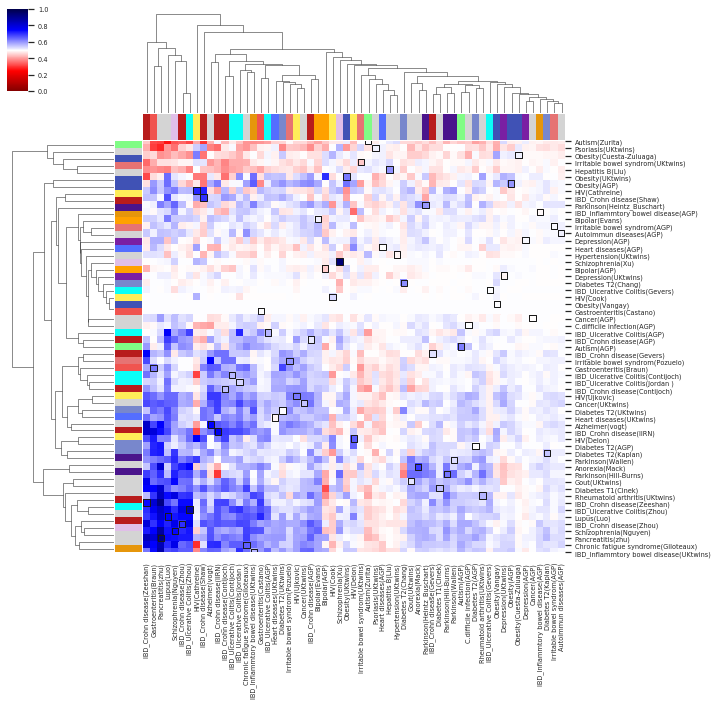

In [14]:
f=plot_clustergram(accreal, studies,metric='braycurtis')
f.savefig('../figures/fig5/ensemble-classifier-accuracy.pdf')

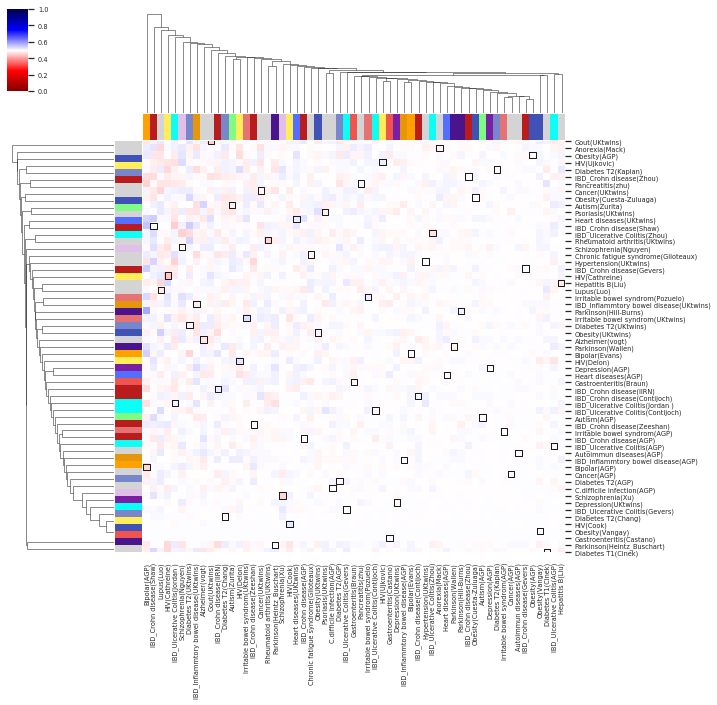

In [15]:
f=plot_clustergram(accshufdest,studies,metric='braycurtis')
f.savefig('../figures/fig5/ensemble-classifier-accuracy-shuffle-dest.pdf')

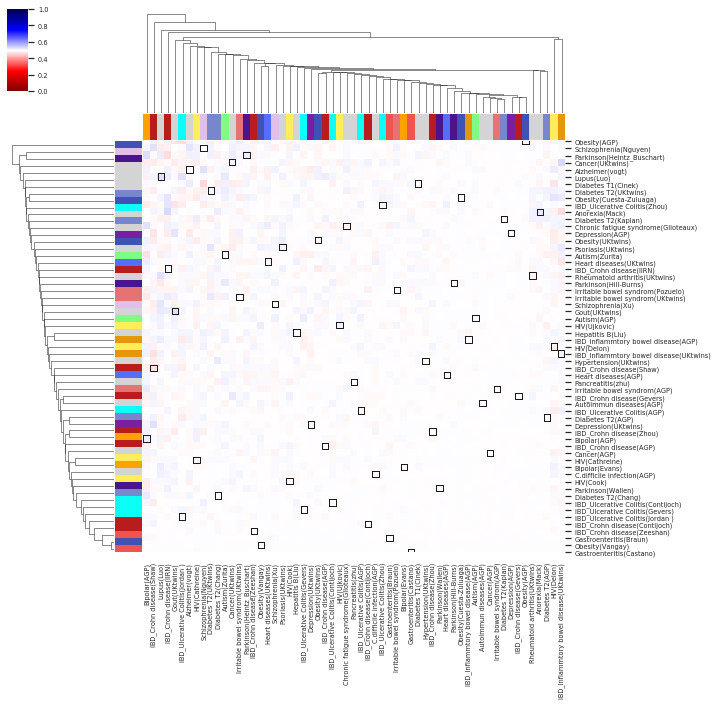

In [16]:
f=plot_clustergram(accshufall,studies,metric='braycurtis')
f.savefig('../figures/fig5/ensemble-classifier-accuracy-shuffle-all.pdf')

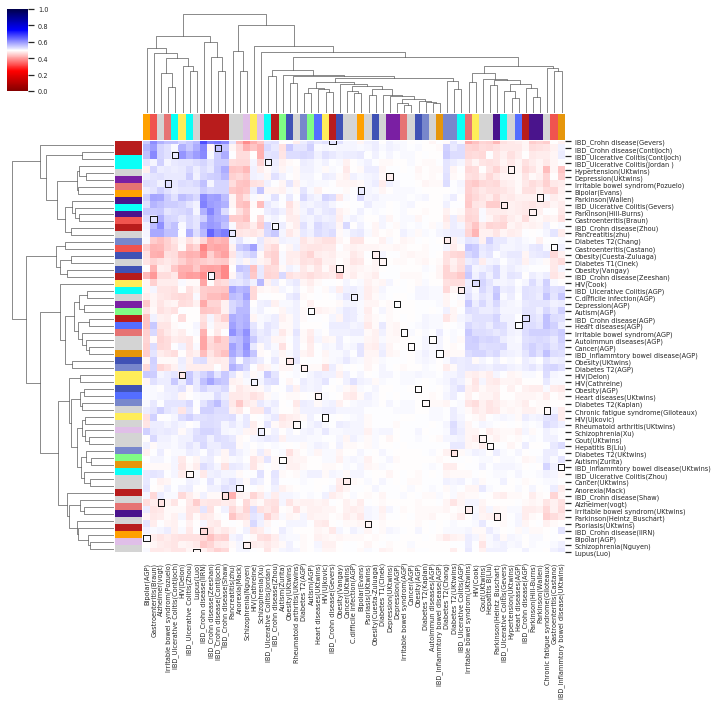

In [17]:
f=plot_clustergram(accshufsrc,studies,metric='braycurtis')
f.savefig('../figures/fig5/ensemble-classifier-accuracy-shuffle-source.pdf')

In [18]:
studies

,sampleid,disease,authors,dys_number,merged,study,Country,sample_source,updated,notes,2,3,4,5,mf
0,17,Alzheimer,vogt,1,Alzheimer (Vogt),vogt,USA,stool,V,1000,adults,1000,1000.0,1000.0,17
1,11,Anorexia,Mack,2,Anorexia (Mack),Mack,Germany,stool,V,no age/gender metadata,1000,1000,1000.0,1000.0,11
2,48,Autism,AGP,3,Autism (AGP),AGP,USA,stool,V,1000,1000,1000,1000.0,1000.0,48
3,50,Autism,Zurita,4,Autism (Zurita),zurita,Ecuador,stool,V,1000,children,1000,1000.0,1000.0,50
4,37,Autoimmun diseases,AGP,5,Autoimmun diseases (AGP),AGP,USA,stool,V,1000,1000,1000,1000.0,1000.0,37
5,36,Bipolar,AGP,6,Bipolar (AGP),AGP,USA,stool,V,1000,1000,1000,1000.0,1000.0,36
6,2,Bipolar,Evans,7,Bipolar (Evans),Evans,USA,stool,V,good,1000,1000,1000.0,1000.0,2
7,40,C.difficile infection,AGP,8,C.difficile infection (AGP),AGP,USA,stool,V,1000,1000,1000,1000.0,1000.0,40
8,46,Cancer,AGP,9,Cancer (AGP),AGP,USA,stool,V,1000,1000,1000,1000.0,1000.0,46
9,58,Cancer,UKtwins,10,Cancer (Uktwins),uktwins,UK,stool,V,females,adults,1000,1000.0,1000.0,58


# whats going on with #36 (bipolar agp)

In [19]:
allres=[]
for i in range(25):
    exp1=dat.filter_samples('expid','36')
    exp1=exp1.downsample('type',axis='s')

#     exp1.sample_metadata['type'] = exp1.sample_metadata['type'].sample(frac=1).values    
    
    exp1.sample_metadata.disease.unique()
    exp1 = exp1.filter_sum_abundance(0,strict=True)
    exp1.sparse=False
    
    cexp1 = exp1.downsample('expid',keep=2*int(len(exp1.sample_metadata)/3))
    cexp2 = exp1.filter_ids(cexp1.sample_metadata.index,axis='s',negate=True)

    model=cu.classify_fit(cexp1,'type')
    res=cu.classify_predict(cexp2, 'type', model,plot_it=False)
    roc_auc = cu.classify_get_roc(res)
    if not np.isnan(roc_auc):
        allres.append(roc_auc)
print(allres)
print(np.mean(allres))
print(np.std(allres))

ValueError: Field expid not in sample_metadata. (fields are: Index(['type', 'disease_cohort', 'age', '_sample_id',
       '_calour_original_abundance', 'exp', '../studies/59', 'host_subject',
       'title', 'host_sex',
       ...
       '../studies/13', 'Isolation_source', 'sequencing_lab', '../studies/5',
       '../studies/14', '../studies/22', 'Sample', 'rep', 'sample_type',
       '../studies/25'],
      dtype='object', length=344))

In [ ]:
exp1 = exp1.filter_sum_abundance(0,strict=True)
exp1.sparse=False

In [ ]:
cexp1 = exp1.downsample('expid',keep=2*int(len(exp1.sample_metadata)/3))
cexp2 = exp1.filter_ids(cexp1.sample_metadata.index,axis='s',negate=True)


In [ ]:
cexp1

In [ ]:
cexp2

In [ ]:
exp1

In [ ]:
model=cu.classify_fit(cexp1,'type')


In [ ]:
res=cu.classify_predict(cexp2, 'type', model,plot_it=True)
roc_auc = cu.classify_get_roc(res)
roc_auc

In [ ]:
cexp1.data.std(axis=1)

In [ ]:
cexp2.data.std(axis=1)

In [ ]:
exp1.data.std(axis=1)

In [ ]:
roc_auc = cu.classify_get_roc(res)


In [ ]:
roc_auc

In [ ]:
cexp1.sample_metadata.type.value_counts()

In [ ]:
exp1.sample_metadata

In [ ]:
cexp2.sample_metadata

In [ ]:
cexp1.sample_metadata

In [ ]:
exp1.sparse=False

In [ ]:
exp1.data

In [ ]:
tt=exp1.downsample('type',axis='s')

In [ ]:
tt.sample_metadata.type.value_counts()

In [ ]:
exp1.sample_metadata.type.value_counts()